# 1.  IMPORTING LIBRARIES AND PACKAGES 

In [149]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist


#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# 2. SCRAPING POSTAL CODE MADRID INFORMATION

In [153]:
url = 'https://www.geonames.org/postalcode-search.html?q=madrid&country=ES'
DataMadrid = pd.read_html(url)
DataMadrid = DataMadrid[2]
DataMadrid
DataMadrid = DataMadrid.drop(DataMadrid.columns[0],axis=1) 
DataMadrid = DataMadrid.drop(DataMadrid.columns[5:len(DataMadrid.columns)],axis=1).reset_index(drop=True) 
#Rename Columns
cols = list(DataMadrid.columns)
cols[0] = 'Neighborhood'
cols[3] = 'State'
cols[4] = 'Province'
DataMadrid.columns = cols
DataMadrid = DataMadrid.drop(len(DataMadrid.index)-1).reset_index(drop=True) 
DataMadrid.head()

,Neighborhood,Code,Country,State,Province
0,Madrid,28054,Spain,Madrid,Madrid
1,40.417/-3.703,40.417/-3.703,40.417/-3.703,40.417/-3.703,40.417/-3.703
2,Madrid,28055,Spain,Madrid,Madrid
3,40.417/-3.703,40.417/-3.703,40.417/-3.703,40.417/-3.703,40.417/-3.703
4,Humanes De Madrid,28970,Spain,Madrid,Madrid


## Converting scraped information in dataframe and exploring it

In [154]:
lat = [] 
long = [] 
for count, n in enumerate(DataMadrid['Neighborhood']):
    if (count % 2 != 0):
        temp = n.split('/')
        lat.append(temp[0])
        long.append(temp[1])
        DataMadrid = DataMadrid.drop(count)
DataMadrid = DataMadrid.reset_index(drop=True)

DataMadrid
#add Latitude and Logitude to LA Dataframe
data = {'Latitude':lat,'Longitude':long}
temp = pd.DataFrame(data,dtype='float')
DataMadrid = DataMadrid.join(temp)
DataMadrid = DataMadrid[DataMadrid['Province'].str.contains('Madrid')] #Select only zip codes in Madrid
DataMadrid.head()


,Neighborhood,Code,Country,State,Province,Latitude,Longitude
0,Madrid,28054,Spain,Madrid,Madrid,40.417,-3.703
1,Madrid,28055,Spain,Madrid,Madrid,40.417,-3.703
2,Humanes De Madrid,28970,Spain,Madrid,Madrid,40.250,-3.831
3,Las Rozas De Madrid,28231,Spain,Madrid,Madrid,40.493,-3.874
4,Las Rozas De Madrid,28232,Spain,Madrid,Madrid,40.493,-3.874


In [18]:

DataMadrid = DataMadrid.sort_values(by = ['Latitude','Longitude']).reset_index(drop=True)

for (row) in range(len(DataMadrid.index)-1):
    if DataMadrid.loc[row,'Latitude'] == DataMadrid.loc[row+1,'Latitude']:
        if DataMadrid.loc[row,'Longitude'] == DataMadrid.loc[row+1,'Longitude']:
            DataMadrid = DataMadrid.drop(row)

DataMadrid = DataMadrid.sort_values('Code').reset_index(drop=True)

In [19]:
print('Rows:',DataMadrid.shape[0],'\nColumns:',DataMadrid.shape[1])
DataMadrid.head()

Rows: 81 
Columns: 7


,Neighborhood,Code,Country,State,Province,Latitude,Longitude
0,El Pardo,28048,Spain,Madrid,Madrid,40.515,-3.773
1,Madrid,28087,Spain,Madrid,Madrid,40.417,-3.703
2,Poligono Industrial El Nogal,28119,Spain,Madrid,Madrid,40.597,-3.497
3,Alalpardo,28130,Spain,Madrid,Madrid,40.627,-3.473
4,Valdeolmos,28130,Spain,Madrid,Madrid,40.637,-3.451


## Using geopy library to getting the latitude and longitude values of Madrid

In [29]:

address = 'Madrid, ES'

geolocator = Nominatim(user_agent="madrid_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Madrid are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Madrid are 40.4167047, -3.7035825.


## Creating a map of Madrid with neighborhoods superimposed on top.

In [30]:
# create map of Madrid using latitude and longitude values
map_madrid = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, province, neighborhood in zip(DataMadrid['Latitude'], DataMadrid['Longitude'], DataMadrid['Province'], DataMadrid['Neighborhood']):
    label = '{}, {}'.format(neighborhood, province)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid)  
    
map_madrid

## Defining Foursquare Credentials

In [31]:

CLIENT_ID = '2IVV030KWKTSMMIK0VSHUNFFFIZOVT2NGQ4ML4OB5DUHPL1P' # your Foursquare ID
CLIENT_SECRET = 'PN3ZEMKXWZOJCC4VSOYOYEPXVHHL5X0M0Y4OWDI1TWKEZYDM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2IVV030KWKTSMMIK0VSHUNFFFIZOVT2NGQ4ML4OB5DUHPL1P
CLIENT_SECRET:PN3ZEMKXWZOJCC4VSOYOYEPXVHHL5X0M0Y4OWDI1TWKEZYDM


## Getting  the top 100 venues that are in Madrid  within a radius of 500 meters

In [32]:
neighborhood_latitude = DataMadrid.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = DataMadrid.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = DataMadrid.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of El Pardo are 40.515, -3.773.


In [77]:
radius = 500
LIMIT = 1000

recommends = []
for lat, long, post, borough, neighborhood in zip(DataMadrid['Latitude'], DataMadrid['Longitude'], DataMadrid['Code'], DataMadrid['State'], DataMadrid['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    postal_data = requests.get(url).json()["response"]['groups'][0]['items']
    for recommend_post in postal_data:
        recommends.append((
            post, 
            borough,
            neighborhood,
            lat, 
            long, 
            recommend_post['venue']['name'], 
            recommend_post['venue']['location']['lat'], 
            recommend_post['venue']['location']['lng'],  
            recommend_post['venue']['categories'][0]['name']))

In [78]:
madrid_recommends = pd.DataFrame(recommends)
madrid_recommends.columns = ['PostalCode',  'Borough', 'Neighborhoods', 'Borough_Lat', 'Borough_Long', 'Venue_Name', 'Venue_Lat', 'Venue_Long', 'Venue_Category']
print("Shape of all the recommendations of all the Postal Codes in Madrid - ", madrid_recommends.shape)
madrid_recommends.head()


Shape of all the recommendations of all the Postal Codes in Madrid -  (436, 9)


,PostalCode,Borough,Neighborhoods,Borough_Lat,Borough_Long,Venue_Name,Venue_Lat,Venue_Long,Venue_Category
0,28048,Madrid,El Pardo,40.515,-3.773,S.Q.,40.514332,-3.773295,Gym
1,28048,Madrid,El Pardo,40.515,-3.773,Al otro lado,40.515907,-3.774495,Café
2,28048,Madrid,El Pardo,40.515,-3.773,El Bodegón,40.517490,-3.772643,Wine Bar
3,28048,Madrid,El Pardo,40.515,-3.773,La Montaña,40.518733,-3.775394,Spanish Restaurant
4,28087,Madrid,Madrid,40.417,-3.703,Puerta del Sol,40.417027,-3.703443,Plaza


In [79]:
print('There are {} uniques categories.'.format(len(madrid_recommends['Venue_Category'].unique())))

There are 114 uniques categories.


# Analyzing Neigborhoods

In [127]:
# one hot encoding
madrid_onehot = pd.get_dummies(madrid_recommends[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
madrid_onehot['Neighborhoods'] = madrid_recommends['Neighborhoods'] 

# move neighborhood column to the first column
fixed_columns = [madrid_onehot.columns[-1]] + list(madrid_onehot.columns[:-1])
madrid_onehot = madrid_onehot[fixed_columns]

madrid_onehot.head()

,Neighborhoods,Airport,American Restaurant,Argentinian Restaurant,Art Museum,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Stadium,Bed & Breakfast,Big Box Store,Bike Trail,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Station,Café,Campground,Casino,Chinese Restaurant,Chocolate Shop,City,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner,Dog Run,Electronics Store,Event Service,Falafel Restaurant,Fast Food Restaurant,Financial or Legal Service,Food,Food & Drink Shop,Furniture / Home Store,Gastropub,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Health Food Store,History Museum,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Kids Store,Lake,Light Rail Station,Liquor Store,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Mountain,Music Venue,Optical Shop,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Pharmacy,Pizza Place,Plaza,Pool,Pub,Resort,Restaurant,River,Road,Rock Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Spanish Restaurant,Steakhouse,Supermarket,Tapas Restaurant,Tennis Court,Theater,Trail,Train Station,Tram Station,Water Park,Wine Bar,Wine Shop,Wings Joint,Zoo
0,El Pardo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,El Pardo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,El Pardo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,El Pardo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Madrid,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [128]:
madrid_onehot.shape

(436, 115)

In [129]:

madrid_grouped = madrid_onehot.groupby('Neighborhoods').mean().reset_index()
madrid_grouped.head()

,Neighborhoods,Airport,American Restaurant,Argentinian Restaurant,Art Museum,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Stadium,Bed & Breakfast,Big Box Store,Bike Trail,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Station,Café,Campground,Casino,Chinese Restaurant,Chocolate Shop,City,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner,Dog Run,Electronics Store,Event Service,Falafel Restaurant,Fast Food Restaurant,Financial or Legal Service,Food,Food & Drink Shop,Furniture / Home Store,Gastropub,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Health Food Store,History Museum,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Kids Store,Lake,Light Rail Station,Liquor Store,Mediterranean Restaurant,Memorial Site,Metro Station,Mexican Restaurant,Mountain,Music Venue,Optical Shop,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Pharmacy,Pizza Place,Plaza,Pool,Pub,Resort,Restaurant,River,Road,Rock Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Skate Park,Smoke Shop,Snack Place,Soccer Field,Spanish Restaurant,Steakhouse,Supermarket,Tapas Restaurant,Tennis Court,Theater,Trail,Train Station,Tram Station,Water Park,Wine Bar,Wine Shop,Wings Joint,Zoo
0,Ajalvir,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.2,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alalpardo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.5,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alpedrete,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.2,0.0,0.0,0.2,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0
3,Ambite,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Anchuelo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:

madrid_grouped.shape

(70, 115)

In [131]:
num_top_venues = 5

for hood in madrid_grouped['Neighborhoods']:
    print("----"+hood+"----")
    temp = madrid_grouped[madrid_grouped['Neighborhoods'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Ajalvir----
                      venue  freq
0                     Hotel   0.2
1              Dessert Shop   0.2
2  Mediterranean Restaurant   0.2
3    Furniture / Home Store   0.2
4        Spanish Restaurant   0.2


----Alalpardo----
                venue  freq
0  Spanish Restaurant  0.50
1        Soccer Field  0.25
2        Tennis Court  0.25
3       Memorial Site  0.00
4            Pharmacy  0.00


----Alpedrete----
                      venue  freq
0        Spanish Restaurant   0.2
1               Wings Joint   0.2
2  Mediterranean Restaurant   0.2
3          Tapas Restaurant   0.2
4                       Bar   0.2


----Ambite----
               venue  freq
0     Scenic Lookout   0.5
1  Electronics Store   0.5
2            Airport   0.0
3           Mountain   0.0
4        Pizza Place   0.0


----Anchuelo----
                venue  freq
0          Bike Trail   1.0
1  Mexican Restaurant   0.0
2               Plaza   0.0
3         Pizza Place   0.0
4            Pharmacy   0.0




4        Bakery  0.11


----Poligono Industrial El Nogal----
                  venue  freq
0                 Hotel   0.2
1  Fast Food Restaurant   0.2
2           Pizza Place   0.2
3                  Park   0.2
4           Snack Place   0.2


----Quijorna----
                        venue  freq
0                Soccer Field  0.25
1          Spanish Restaurant  0.25
2                  Restaurant  0.25
3  Construction & Landscaping  0.25
4                   Irish Pub  0.00


----Rio, El (Urbanizacion)----
         venue  freq
0  Music Venue   1.0
1      Airport   0.0
2         Pool   0.0
3  Pizza Place   0.0
4     Pharmacy   0.0


----Robledondo----
          venue  freq
0  Optical Shop   1.0
1       Airport   0.0
2          Pool   0.0
3   Pizza Place   0.0
4      Pharmacy   0.0


----Santorcaz----
              venue  freq
0             Hotel   0.5
1  Tapas Restaurant   0.5
2     Metro Station   0.0
3       Pizza Place   0.0
4          Pharmacy   0.0


----Somosierra----
               

In [132]:
madridEncode = pd.get_dummies(madrid_recommends[['Venue_Category']], prefix="", prefix_sep="")
madridEncode['Neighborhoods'] = madrid_recommends['Neighborhoods']
fixed_columns = [madridEncode.columns[-1]] + list(madridEncode.columns[:-1])
madridEncode = madridEncode[fixed_columns]
madridSorted = madridEncode.groupby(by='Neighborhoods').mean().reset_index()
madridCluster = madridSorted.drop('Neighborhoods', axis=1)

In [133]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [160]:

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sort = pd.DataFrame(columns=columns)
neighborhoods_venues_sort['Neighborhoods'] = madrid_grouped['Neighborhoods']

for ind in np.arange(madrid_grouped.shape[0]):
    neighborhoods_venues_sort.iloc[ind, 1:] = return_most_common_venues(madrid_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sort.head()

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ajalvir,Hotel,Furniture / Home Store,Dessert Shop,Spanish Restaurant,Mediterranean Restaurant,Zoo,Event Service,Concert Hall,Construction & Landscaping,Convenience Store
1,Alalpardo,Spanish Restaurant,Tennis Court,Soccer Field,Zoo,Event Service,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop
2,Alpedrete,Tapas Restaurant,Wings Joint,Spanish Restaurant,Bar,Mediterranean Restaurant,Zoo,Electronics Store,Dog Run,Diner,Department Store
3,Ambite,Scenic Lookout,Electronics Store,Zoo,Event Service,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio
4,Anchuelo,Bike Trail,Zoo,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner


# 3. CLUSTER NEIGHBORHOODS ALGORITHM

## Determining the number of cluster

In [161]:

# Let's determine the number of clusters using the elbow method

Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(madridCluster)
    Sum_of_squared_distances.append(km.inertia_)

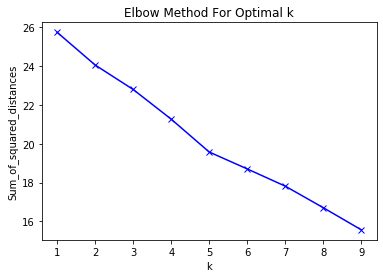

In [162]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

There is no clear and unique elbow in the graph, however it seems that there is an inflexion at 5. We will use this value for the number of clusters.

In [163]:

# set number of clusters
k = 5
kmeans = KMeans(k, random_state=0).fit(madridCluster)

In [164]:
# add clustering labels
neighborhoods_venues_sort.insert(0,'Cluster Labels',kmeans.labels_)

In [165]:
# Join Zipcodes & Coordinates with Cluster Labels and Top Venues
madridFinal = pd.DataFrame()
madridFinal = DataMadrid.loc[:,['Province','Code','Latitude','Longitude']].sort_values(by='Code').reset_index(drop=True)
for x in madrid_recommends:
    if madridFinal['Code'].str.contains(x).any():
        madridFinal = madridFinal.drop(madridFinal.index[madridFinal['Code']==x])
madridFinal = madridFinal.reset_index(drop=True)
madridFinal = madridFinal.join(neighborhoods_venues_sort)
madridFinal = madridFinal.sort_values('Cluster Labels').reset_index(drop=True)
madridFinal.head(100)

,Province,Code,Latitude,Longitude,Cluster Labels,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Madrid,28035,40.417,-3.703,0.0,Navalafuente,Park,Café,Bar,Zoo,Falafel Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store
1,Madrid,28119,40.597,-3.497,0.0,Villalbilla,Park,Zoo,Cocktail Bar,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop
2,Madrid,28049,40.417,-3.703,1.0,Santorcaz,Hotel,Tapas Restaurant,Zoo,Falafel Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store
3,Madrid,28031,40.417,-3.703,1.0,Madarcos,Tapas Restaurant,Zoo,Falafel Restaurant,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store
4,Madrid,28110,40.597,-3.497,2.0,Venturada,Mediterranean Restaurant,Zoo,Falafel Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop
5,Madrid,28051,40.417,-3.703,2.0,Tielmes,Restaurant,Zoo,Event Service,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store
6,Madrid,28020,40.417,-3.703,2.0,Estremera,Restaurant,Zoo,Event Service,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store
7,Madrid,28012,40.417,-3.703,2.0,Cerceda,Mediterranean Restaurant,Restaurant,Supermarket,Spanish Restaurant,Zoo,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop
8,Madrid,28130,40.637,-3.451,2.0,Villamantilla,Mediterranean Restaurant,Construction & Landscaping,Restaurant,Falafel Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop
9,Madrid,28010,40.417,-3.703,3.0,Casarrubuelos,Restaurant,Basketball Stadium,Soccer Field,Zoo,Falafel Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio


## Analizing the differents clusters

In [166]:
print('K    Count\n-----------')
print(madridFinal['Cluster Labels'].value_counts(sort=False))

K    Count
-----------
0.0     2
1.0     2
2.0     5
3.0    59
4.0     2
Name: Cluster Labels, dtype: int64


In [167]:
#madridfinal['Cluster Labels'].astype(int)

madridFinal['Cluster Labels'] = madridFinal['Cluster Labels'].fillna(0).astype(int)
madridFinal

,Province,Code,Latitude,Longitude,Cluster Labels,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Madrid,28035,40.417,-3.703,0,Navalafuente,Park,Café,Bar,Zoo,Falafel Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store
1,Madrid,28119,40.597,-3.497,0,Villalbilla,Park,Zoo,Cocktail Bar,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop
2,Madrid,28049,40.417,-3.703,1,Santorcaz,Hotel,Tapas Restaurant,Zoo,Falafel Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store
3,Madrid,28031,40.417,-3.703,1,Madarcos,Tapas Restaurant,Zoo,Falafel Restaurant,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store
4,Madrid,28110,40.597,-3.497,2,Venturada,Mediterranean Restaurant,Zoo,Falafel Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop
5,Madrid,28051,40.417,-3.703,2,Tielmes,Restaurant,Zoo,Event Service,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store
6,Madrid,28020,40.417,-3.703,2,Estremera,Restaurant,Zoo,Event Service,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store
7,Madrid,28012,40.417,-3.703,2,Cerceda,Mediterranean Restaurant,Restaurant,Supermarket,Spanish Restaurant,Zoo,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop
8,Madrid,28130,40.637,-3.451,2,Villamantilla,Mediterranean Restaurant,Construction & Landscaping,Restaurant,Falafel Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop
9,Madrid,28010,40.417,-3.703,3,Casarrubuelos,Restaurant,Basketball Stadium,Soccer Field,Zoo,Falafel Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio


In [168]:
madridFinal.loc[madridFinal['Cluster Labels'] ==0, madridFinal.columns[[1] + list(range(5, madridFinal.shape[1]))]]

,Code,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,28035,Navalafuente,Park,Café,Bar,Zoo,Falafel Restaurant,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store
1,28119,Villalbilla,Park,Zoo,Cocktail Bar,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop
70,28130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,28160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,28170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,28180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,28189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,28189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,28189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,28191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [169]:
madridFinal.loc[madridFinal['Cluster Labels'] == 1, madridFinal.columns[[1] + list(range(5, madridFinal.shape[1]))]]

,Code,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,28049,Santorcaz,Hotel,Tapas Restaurant,Zoo,Falafel Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store
3,28031,Madarcos,Tapas Restaurant,Zoo,Falafel Restaurant,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store


In [170]:
madridFinal.loc[madridFinal['Cluster Labels'] == 2, madridFinal.columns[[1] + list(range(5, madridFinal.shape[1]))]]

,Code,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,28110,Venturada,Mediterranean Restaurant,Zoo,Falafel Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop
5,28051,Tielmes,Restaurant,Zoo,Event Service,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store
6,28020,Estremera,Restaurant,Zoo,Event Service,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store
7,28012,Cerceda,Mediterranean Restaurant,Restaurant,Supermarket,Spanish Restaurant,Zoo,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop
8,28130,Villamantilla,Mediterranean Restaurant,Construction & Landscaping,Restaurant,Falafel Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop


In [171]:
madridFinal.loc[madridFinal['Cluster Labels'] == 3, madridFinal.columns[[1] + list(range(5, madridFinal.shape[1]))]]

,Code,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,28010,Casarrubuelos,Restaurant,Basketball Stadium,Soccer Field,Zoo,Falafel Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio
10,28042,Patones,Pharmacy,Restaurant,Bar,Food,Event Service,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop
11,28043,Pedrezuela,Spanish Restaurant,Steakhouse,Food,Café,Brewery,Zoo,Dessert Shop,Dog Run,Diner,Department Store
12,28044,Peralejo,Restaurant,Zoo,Steakhouse,Plaza,Art Museum,Event Service,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store
13,28045,Poligono Industrial De Pinto,Park,Plaza,Bakery,Grocery Store,Pizza Place,Train Station,Burger Joint,Bus Station,Dessert Shop,Department Store
14,28046,Poligono Industrial El Nogal,Snack Place,Hotel,Park,Fast Food Restaurant,Pizza Place,Electronics Store,Coffee Shop,Concert Hall,Construction & Landscaping,Convenience Store
15,28047,Quijorna,Construction & Landscaping,Restaurant,Spanish Restaurant,Soccer Field,Zoo,Event Service,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop
16,28048,"Rio, El (Urbanizacion)",Music Venue,Zoo,Cocktail Bar,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop
17,28048,Robledondo,Optical Shop,Zoo,Cocktail Bar,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop
18,28005,Anchuelo,Bike Trail,Zoo,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop,Diner


In [172]:
madridFinal.loc[madridFinal['Cluster Labels'] == 4, madridFinal.columns[[1] + list(range(5, madridFinal.shape[1]))]]

,Code,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
68,28029,Las Charquillas,Bar,Zoo,Fast Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop
69,28037,Navalespino,Bar,Zoo,Fast Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Department Store,Dessert Shop


## 4. CONCLUSION:
# We think the best cluster to open a new bar would be cluster number==1, which main feature are Hotels, Restaurants Tapas, Concert Hall and differents shops. All these places are very popular for the tourists
